## This notebook will help you train a latent Point-Cloud GAN.

(Assumes latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.point_net_ae import PointNetAutoEncoder
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import latent_code_discriminator_two_layers,\
latent_code_generator_two_layers

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Specify where the raw point-clouds and the pre-trained AE are.

In [9]:
# Top-dir of where point-clouds are stored.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/'    

ae_configuration = '../data/single_class_ae/configuration'

In [3]:
# Where to save GANs check-points etc.
top_out_dir = '../data/'
experiment_name = 'latent_gan_with_chamfer_ae'

ae_epoch = 500           # Epoch of AE to load.
bneck_size = 128         # Bottleneck-size of the AE
n_pc_points = 2048       # Number of points per model.

class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


In [6]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
print 'Shape of DATA =', all_pc_data.point_clouds.shape

6778 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (6778, 2048, 3)


In [10]:
# Load pre-trained AE
reset_tf_graph()
ae_conf = Conf.load(ae_configuration)
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
ae.restore_model(ae_conf.train_dir, ae_epoch, verbose=True)

INFO:tensorflow:Restoring parameters from ../data/single_class_ae/models.ckpt-500
Model restored in epoch 500.


In [11]:
# Use AE to convert raw pointclouds to latent codes.
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)
latent_data = PointCloudDataSet(latent_codes)
print 'Shape of DATA =', latent_data.point_clouds.shape

Shape of DATA = (6778, 128)


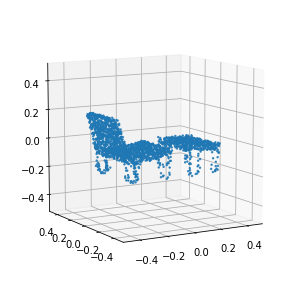

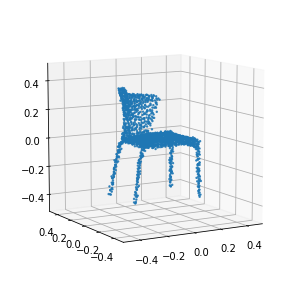

In [12]:
# Check the decoded AE latent-codes look descent.
L = ae.decode(latent_codes)
i = 0
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);
i = 20
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);

In [13]:
# Set GAN parameters.

use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 1        # Epochs to train.

plot_train_curve = True
save_gan_model = False
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = latent_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = bneck_size
beta = 0.5 # ADAM's momentum.

n_out = [bneck_size] # Dimensionality of generated samples.

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/latent_gan', experiment_name)
    create_dir(train_dir)

In [14]:
reset_tf_graph()

if use_wgan:
    lam = 10 # lambda of W-GAN-GP
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim, \
                  latent_code_discriminator_two_layers, 
                  latent_code_generator_two_layers,\
                  beta=beta)
else:    
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                     latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                     beta=beta)

In [15]:
accum_syn_data = []
train_stats = []

1 (-1.4845550561392749, -0.1630677901622322)


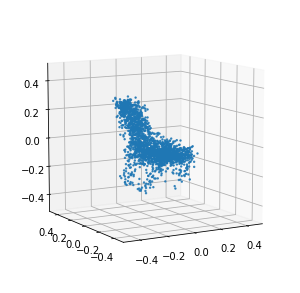

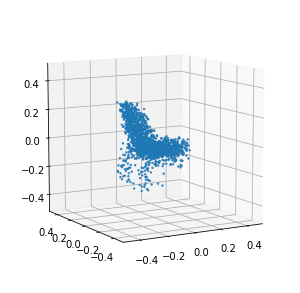

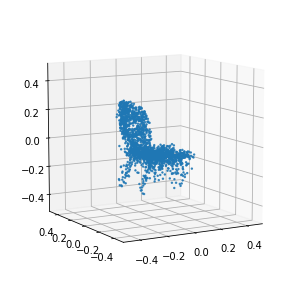

In [16]:
# Train the GAN.
for _ in range(n_epochs):
    loss, duration = gan._single_epoch_train(latent_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
    print epoch, loss

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (syntetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

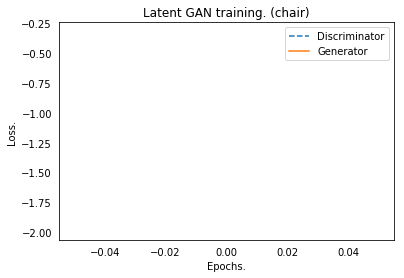

In [54]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s)' %(class_name))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')